# Práctico: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [2]:
# Importacion de librerias y descarga de datos.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import sys
import datetime as dt

in_colab = 'google.colab' in sys.modules

if in_colab:
  !echo "** INSTALLING SURPRISE **"
  !pip install scikit-surprise

  !echo -e "\n** DOWNLOADING FILES **"
  !rm -rf data/lastfm/
  !mkdir -p data/lastfm/
  !curl -LO http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip
  !unzip hetrec2011-lastfm-2k.zip -d data/lastfm/
  !rm -f hetrec2011-lastfm-2k.zip

  DS_FILEPATH = "data/lastfm/"
else: 
  DS_FILEPATH = "../data/lastfm/"

print("\n** IMPORT SURPRISE **")
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise import accuracy
from surprise.accuracy import rmse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from collections import defaultdict
from sklearn import linear_model



print(f"Surpr!se version: {surprise.__version__} imported")


** IMPORT SURPRISE **
Surpr!se version: 1.1.1 imported


In [3]:
artist_data = pd.read_csv(DS_FILEPATH + "artists.dat", sep="\t", usecols=['id','name'])
user_artist_plays = pd.read_csv(DS_FILEPATH + "user_artists.dat", sep="\t")
tags = pd.read_csv(DS_FILEPATH + "tags.dat", sep="\t", encoding = "ISO-8859-1")
user_taggedartists_timestamps = pd.read_csv(DS_FILEPATH + "user_taggedartists-timestamps.dat", sep="\t")
user_tags = user_taggedartists_timestamps.drop(columns = 'timestamp')

## Actividades

El [Ejercicio 1](#Ejercicio-1---Análisis-Exploratorio-de-Datos) deberá ser realizado por quienes estén realizando cualquier parte de la materia.

El [Ejercicio 2](#Ejercicio-2---Sistema-de-Recomendación) variará de acuerdo a que parte de la materia estén realizando, quienes estén realizando la materia completa, deberán realizar ambas partes.

De acuerdo a la parte de la materia que hagan, deberán realizar una de las siguientes actividades (pueden realizar ambas si así lo desean):

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar dos sistemas de recomendación: 
1. El primero, más sencillo, utilizando [Surpr!se](http://surpriselib.com/), y a partir de los datos de LastFM, en especial del archivo `./data/lastfm/user_artists.dat`, generar un sistema de recomendación basado en filtros colaborativos.
2. En el segundo, deberán utilizar todos los datos ofrecidos en el dataset de LastFM para generar un sistema de filtrado colaborativo más complejo, deberá utilizar las técnicas aprendidas 

basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [4]:
print("Cantidad de filas en los datasets:")
print("   artist_data:       {}".format(artist_data.shape[0]))
print("   user_artist_plays: {}\n".format(user_artist_plays.shape[0]))

print("Columnas:")
print("   artist_data:       {}".format(artist_data.columns))
print("   user_artist_plays: {}\n".format(user_artist_plays.columns))

print("weight min: {}, weight max {}".format(user_artist_plays.weight.min(), user_artist_plays.weight.max()))

Cantidad de filas en los datasets:
   artist_data:       17632
   user_artist_plays: 92834

Columnas:
   artist_data:       Index(['id', 'name'], dtype='object')
   user_artist_plays: Index(['userID', 'artistID', 'weight'], dtype='object')

weight min: 1, weight max 352698


In [5]:
# Union de los datasets
ds_plays = pd.merge(user_artist_plays,artist_data,
                        how="inner",
                        left_on="artistID",
                        right_on="id")

del ds_plays['id']
ds_plays = ds_plays.rename(columns={'name': 'artistName', 'weight': 'playCounts'})
ratings = ds_plays.rename(columns={'name': 'artistName', 'playCounts': 'rating'})
ratings['rating'] = ratings['rating']/ratings['rating'].max()

In [6]:
# cantidad de reproducciones de artista por usuario
ds_artist_plays_group = ds_plays.groupby(['userID','artistName','artistID']).sum().reset_index().sort_values(by='playCounts',ascending=False)
# cantidad de usuarios que escuchan a un artistas
ds_art_usr = ds_artist_plays_group.artistName.value_counts().rename_axis(["artista"]).rename('oyentes').reset_index()
# cantidad total de reproducciones
ds_art_rep = ds_artist_plays_group.groupby(['artistID','artistName'])['playCounts'].sum().reset_index().sort_values(by='playCounts',ascending=False)
# cantidad de artistas escuchados por usuario
ds_usr = ds_artist_plays_group.userID.value_counts().rename_axis(["userID"]).rename('oyentes').reset_index()
# cantidad de listens que tiene cada usuario
ds_usr_rep = ds_artist_plays_group.groupby(['userID'])['playCounts'].sum().reset_index().sort_values(by='playCounts',ascending=False)
# géneros y tagID por artistas y usuario
ds_users_tags = pd.merge(tags, user_tags,how="inner",left_on="tagID",right_on="tagID")
# conteo de etiquetas
ds_tags_counts = ds_users_tags["tagValue"].value_counts().rename_axis(["tagValue"]).rename('count').sort_values(ascending=False).reset_index()
# elimino las etiquetas menos frecuentes y las agrupo por artistas
ds_tags = pd.merge(ds_users_tags,ds_tags_counts,how="inner",left_on=['tagValue'],right_on=['tagValue'])
quantile = ds_tags['count'].quantile(q=0.4)
ds_tags = ds_tags[ds_tags['count']>quantile]

ds_tags['tagID'] = ds_tags['tagID'].astype(str)
ds_tags = ds_tags.groupby(['artistID'])[['tagID','tagValue']].agg(','.join).reset_index()

# #### Normalizacion de algunos tags. Se podrian normalizar los años/decadas.
ds_tags.tagValue = ds_tags.tagValue.str.replace('-', ' ')

# genres_normalize_dict = {
#     'brasil': 'brazilian',
#     'brazil': 'brazilian',
#     'chill': 'chillout',
#     'cover': 'covers',
#     'electronic': 'electro',
#     'electronica': 'electro',
#     'favorite songs' : 'favorite',
#     'favorites' : 'favorite',
#     'female' : 'female vocalist',
#     'female vocalists': 'female vocalist',
#     'fucking awesome': 'awesome',
#     'love at first listen': 'love songs',
#     'love it': 'love songs',
#     'relaxing': 'relax',    
#     'rock and roll': 'rock',
#     'rock n roll': 'rock',
#     'synthpop': 'synth pop',
#     'christian rock': 'christian'
#  }

# ds_tags.tagValue.replace(genres_normalize_dict, inplace=True)

# preparo dataset artists con id, nombre, géneros
artist_data.columns = ['artistID','artistName']
artists = pd.merge(ds_tags,artist_data,how="left",on=['artistID'])

artists['tagID'] = artists['tagID'].apply(lambda x: list(set(x.split(","))))
artists['genres'] = artists['tagValue'].apply(lambda x: list(set(x.split(","))))

artists = artists[['artistID','artistName','genres']]

Top 10 artistas con más usuarios:


,artista,oyentes
0,Lady Gaga,611
1,Britney Spears,522
2,Rihanna,484
3,The Beatles,480
4,Katy Perry,473
5,Madonna,429
6,Avril Lavigne,417
7,Christina Aguilera,407
8,Muse,400
9,Paramore,399


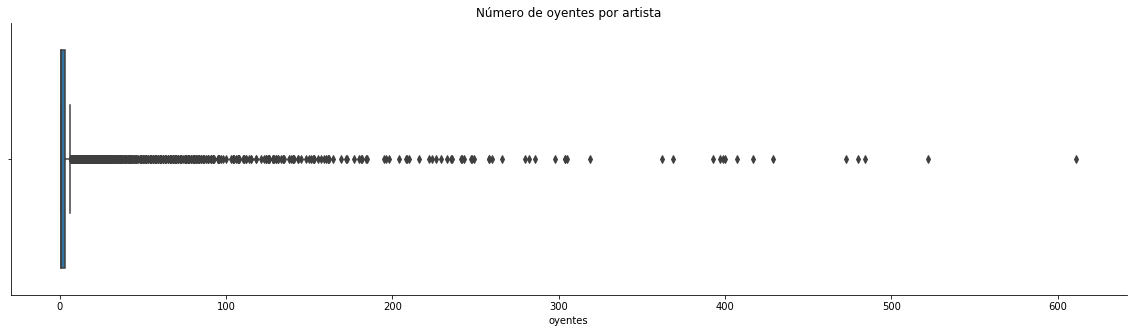

In [7]:
# número de usuarios oyentes de una artista
print('Top 10 artistas con más usuarios:')
display(ds_art_usr.head(10))
print('')
plt.figure(figsize=(20,5))
seaborn.boxplot(x=ds_art_usr.oyentes).set_title('Número de oyentes por artista')
seaborn.despine()

Top 10 artistas con más reproducciones:


,artistID,artistName,playCounts
283,289,Britney Spears,2393140
66,72,Depeche Mode,1301308
83,89,Lady Gaga,1291387
286,292,Christina Aguilera,1058405
492,498,Paramore,963449
61,67,Madonna,921198
282,288,Rihanna,905423
695,701,Shakira,688529
221,227,The Beatles,662116
294,300,Katy Perry,532545


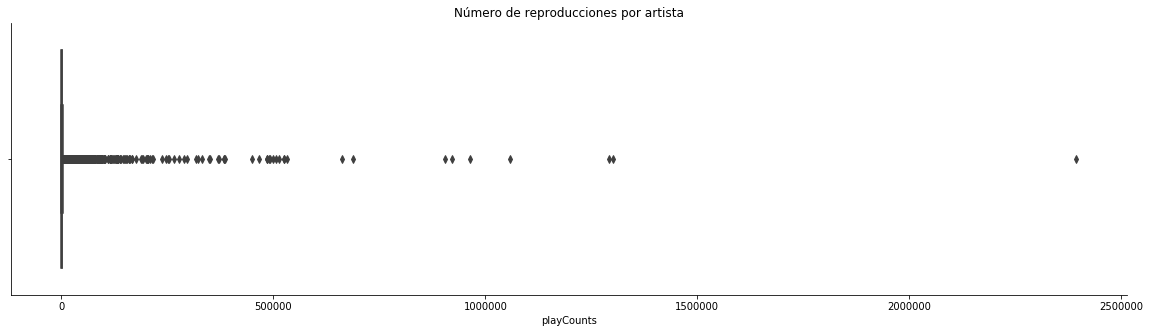

In [8]:
# número de reproducciones de un artista
print('Top 10 artistas con más reproducciones:')
display(ds_art_rep.head(10))
print('')
plt.figure(figsize=(20,5))
seaborn.boxplot(x=ds_art_rep.playCounts).set_title('Número de reproducciones por artista')
seaborn.despine()

Top 10 artistas con más reproducciones:


,userID,artistName,artistID,playCounts
72751,1642,Depeche Mode,72,352698
91681,2071,Thalía,792,324663
49337,1094,U2,511,320725
84247,1905,Blur,203,257978
73773,1664,Paramore,498,227829
51464,1146,Evanescence,378,203165
23738,514,Christina Aguilera,292,176133
87626,1983,Shakira,701,172496
34726,757,Shakira,701,169596
48913,1086,Glee Cast,679,165902


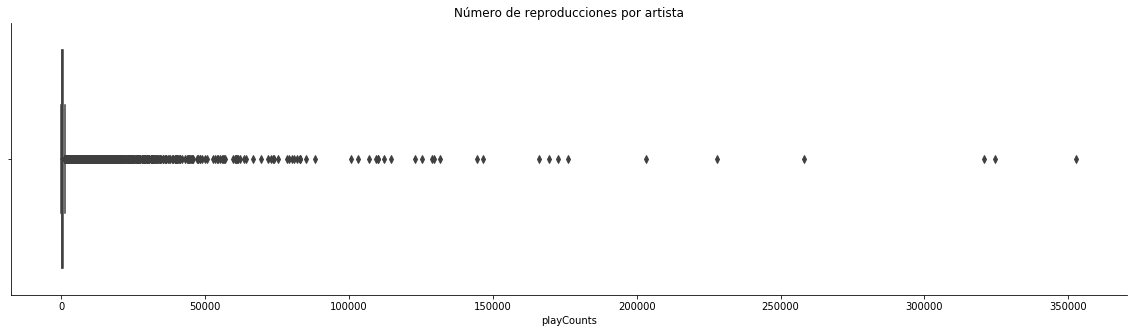

In [9]:
# número de reproducciones de un artista por usuario
print('Top 10 artistas con más reproducciones:')
display(ds_artist_plays_group.head(10))
print('')
plt.figure(figsize=(20,5))
seaborn.boxplot(x=ds_artist_plays_group.playCounts).set_title('Número de reproducciones por artista')
seaborn.despine()

In [10]:
# reproducciones por usuario
rep=ds_usr_rep.describe(percentiles=None)

print('Cantidad de usuarios: {}'.format(int(rep.iloc[0][0])))
print('Número máximo de reproducciones: {}'.format(rep.iloc[-1][1]))
print('Media de reproducciones por usuario: {}'.format(rep.iloc[1][1]))
print('Mediana de reproducciones por usuario: {}'.format(rep.iloc[5][1]))
print('Número mínimo de reproducciones: {}'.format(rep.iloc[3][1]))

Cantidad de usuarios: 1892
Número máximo de reproducciones: 480039.0
Media de reproducciones por usuario: 36566.58298097252
Mediana de reproducciones por usuario: 21573.0
Número mínimo de reproducciones: 3.0


In [12]:
# número de etiquetas más frecuentes
print('Top 10 etiquetas más frecuentes:')
display(ds_tags_counts.head(10))
print('Cantidad de etiquetas únicas: %d' % len(ds_tags_counts['tagValue'].unique()))

plt.figure(figsize=(40,10))
g = seaborn.barplot(x='tagValue',y='count',data=ds_tags_counts[:50],color='steelblue',palette='crest_r')

plt.ylabel('Cantidad')
plt.xlabel('Género')
plt.title('Conteo de las 50 etiquetas más frecuentes')
plt.xticks(rotation=90)
seaborn.despine(left=True)

Top 10 etiquetas más frecuentes:


,tagValue,count
0,rock,7503
1,pop,5418
2,alternative,5251
3,electronic,4672
4,indie,4458
5,female vocalists,4228
6,80s,2791
7,dance,2739
8,alternative rock,2631
9,classic rock,2287


Cantidad de etiquetas únicas: 9749


ValueError: crest_r is not a valid palette name

<Figure size 2880x720 with 0 Axes>

## Respuestas Ejercicio 1

**¿Cuáles son los artistas que fueron más escuchados?**

Depende que consideremos como los artistas más escuchados, pero extraimos la siguiente información al respecto:

- Lady Gaga es la artista más escuchada por cantidad de usuarios únicos (611).

- Britney Spears es la artista que acumula mas reproducciones (2393140).

- Depeche Mode es el artista más esuchado por un único usuario  con 352698 reproducciones.

**¿Cómo es la distribución de cantidad de listens por user?**

Observamos que la media es de aproximadamente 36500 reproducciones por usuario.
Mientras que el 50% de los usuarios reprodujeron aprox 21500 temas.

**¿Es posible ver el género más escuchado?**

Contando los tags que usan los usuarios podemos pensar que los géneros más escuchados son:
1. Rock
2. Pop
3. Alternative
4. Electronic
5. Indie


## Ejercicio 2 - Sistema de Recomendación

### Ejercicio 2a - Filtrados Colaborativos

Esta parte del ejercicio es obligatoria para aprobar la parte introductoria de la materia (i.e. los contenidos que se ven en las dos primeras clases), quienes estén realizando la materia completa deerán realizar también el [Ejercicio 2b](#Ejercicio-2b---Sistemas-de-Recomendación-Avanzados). 

Deberán realizar un sistema de filtrados colaborativos basado en [Surpr!se](http://surpriselib.com/), a partir de los datos que proporciona `LastFM`, en especial el archivo `user_artists.dat`. Tener en cuenta los siguientes pasos:

1. **Desarrollo de la matriz de Usuario-Contenido:** A partir del conjunto de datos deberán generar una matriz de usuario-contenido. Tener en cuenta que los ratings son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a determinado artista.
2. **Entrenamiento del algoritmo de recomendación**: Utilizando las herramientas brindadas por [Surpr!se](http://surpriselib.com/), entrenen varios modelos (al menos 3) de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo. Si necesitan inspiración, les recomendamos revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).
3. **Sistema de recomendación**: A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [13]:
# construimos la matriz de Usuario-Contenido.
# esta matriz tiene por sus filas a los usuarios, sus columnas los artistas y
# como valores las ratings del par (usuario, artista) (rating = (num de rep)/(max num reproducciones))
# completamos con 0 los ratings faltantes

matrix_user_content = ratings.pivot_table(index = 'userID', columns = 'artistID', values = 'rating').fillna(0)
matrix_user_content

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Sparsity de la matriz
n_total = matrix_user_content.shape[0]*matrix_user_content.shape[1]
n_nonull = np.count_nonzero(matrix_user_content)
sparsity = n_nonull/n_total
print(f"Sparsity de la matriz Usuario-Contenido: {round(sparsity*100,2)}%")

Sparsity de la matriz Usuario-Contenido: 0.28%


**Benchamark de los algoritmos para el modelos de filtrado colaborativo (usando el dataset completo)**

In [15]:
max_rating = ratings.rating.max()
min_rating = ratings.rating.min()
reader = surprise.Reader(rating_scale = (min_rating,max_rating))
data = surprise.Dataset.load_from_df(ratings[['userID', 'artistID', 'rating']], reader)

In [16]:
# iteramos sobre los siguientes algoritmos de predicción para hacer un benchmark 
# comparando el RMSE y los tiempos de ejecución en los conjuntos training-test

benchmark = []

# (estos son muchos algoritmos, elegir algunos principales)

algorithms_list = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

for algo in algorithms_list:
    # usando cross validation
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)    
    # guardamos el resultado
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

# Resultados del benchmark
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.010402,0.235291,0.266195
KNNBaseline,0.010443,0.553543,3.185271
SlopeOne,0.010531,12.358444,1.524864
KNNWithMeans,0.010553,0.365812,2.690537
KNNBasic,0.010679,0.313016,2.705545
CoClustering,0.010753,2.906729,0.231897
NMF,0.010799,5.612851,0.257627
KNNWithZScore,0.010986,0.441539,2.882535
NormalPredictor,0.013023,0.117926,0.325413


In [17]:
# Sistema de recomendación simple.
# dado que queremos ver los artistas más parecidos entrenaremos un modelo
# que use una métrica de similitud (k-NN inspired algorithms)
# volvemos a evaluar el benchmark comparando sólo los modelos que nos interesan
# y elegimos el mejor

benchmark = []

algorithms_list = [KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]

for algo in algorithms_list:
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

# Resultados del benchmark
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
KNNWithMeans,0.010335,0.358355,2.687066
KNNBaseline,0.010360,0.539259,3.147700
KNNBasic,0.010730,0.294566,2.474301
KNNWithZScore,0.011008,0.455912,2.944217


In [18]:
# Entrenamos el modelo

# creo el reader y cargo los datos
max_rating = ratings.rating.max()
min_rating = ratings.rating.min()
reader = surprise.Reader(rating_scale = (min_rating,max_rating))

# defino los conjuntos de entrenamiento/evalución y entreno el modelo
data = Dataset.load_from_df(ratings[["userID", "artistID", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2)


sim_options = {'name': 'pearson_baseline', 'user_based': False}
cf_model = KNNBaseline(sim_options=sim_options)
cf_model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## Respuestas Ejercicio 2a

**Recomendador de artistas basado en filtrado colaborativo:**



In [19]:
# Con el modelo entrenado calculamos los vecinos de un artista dado

# pido ingresar el nombre de un artista
artist_name = input('Ingrese el nombre de un artista:\n')
done = False
while not done:    
    if len(ratings[ratings['artistName'].str.lower()==artist_name.lower()])==0:
        print('No se encuentra el artista.\nIntente nuevamente.')
        artist_name = input('Ingrese el nombre de un artista:\n')
    else:
        # busco el raw_id (artistID) dado el nombre del artista
        raw_id = ratings[ratings['artistName'].str.lower()==artist_name.lower()]['artistID'].iloc[0]
        # recupero el inner_id desde le raw_id
        inner_id = cf_model.trainset.to_inner_iid(raw_id)
        # obtengo los inner_id's de los vecinos que me dio el modelo
        # k=10 es la cantidad de vecinos a obtener
        neighbors = cf_model.get_neighbors(inner_id, k=5)
        # convierto los id internos a los artistID y así obtengo los nombre
        neighbors = (cf_model.trainset.to_raw_iid(inner_id)
                           for inner_id in neighbors)
        # creo la lista con los artistas encontrados
        lista_artistas = []
        
        for art in neighbors:
            lista_artistas.append(ratings[ratings['artistID']==art]['artistName'].iloc[0])
        # imprimo el pantalla los nombres de los artistas
        print('Los 5 artistas recomendados son:\n'+', '.join(lista_artistas[:-1])+' y '+lista_artistas[-1]+'.')
        done = True

Ingrese el nombre de un artista:
 Queen


Los 5 artistas recomendados son:
Guns N' Roses, The Doors, Nirvana, AC/DC y a-ha.


### Ejercicio 2b - Sistemas de Recomendación Avanzados

Este ejercicio lo deberán completar quienes hayan realizado ambas partes de la materia pues requiere de los conocimientos adquiridos en las segundas dos clases. En este caso, utilizarán no sólo la información de la matriz de usuario-contenido, sino que deberán hacer uso de otra información para poder lidiar con el problema del "Cold Start", i.e. que es lo que ocurre cuando tengo nuevos usuarios o artistas. Tener en cuenta los siguientes pasos:
1. **Evaluación sobre cold start**: Para evaluar como funciona el sistema con el problema del "cold start", deberán tomar ciertos artistas y "dejarlos fuera", i.e. remover cualquier participación del artista en el sistema. Esos serán los artistas que se evaluarán como "cold start".
2. **Vectores de contenido**: Deberán generar vectores de contenido para los artistas, basados en los tags que los usuarios les dan (ver los archivos `user_taggedartists.dat` y `tags.dat`).
3. **Sistema de recomendación**: Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.
4. **Evaluación del sistema**: Deberán evaluar "a mano" el sistema sobre artistas que conozca y artistas que no conozca (i.e. que fueron dejados afuera), y hacer un análisis de lo que el sistema está devolviendo.

### Entrenamiento del modelo con el dataset completo

#### Predictivo basado en contenido

In [21]:
class GenresBasedFilter(object):
    def __init__(self, artists, k=5):
        ## llevar id de artista a índice
        self.artist_to_idx = {row["artistID"]: idx for idx, row in artists.iterrows()}  
        ## llevar índice a id de artista
        self.idx_to_artist = {idx: artist for artist, idx in self.artist_to_idx.items()} 
        ## número de similares
        self.k = k 
        
        genres=[]
        ## construyo los vectores de contenido para los géneros y lo hago en una matriz tripo one-hot encoding
        genres = set(g for G in artists['genres'] for g in G)
        for g in genres:
            artists[g] = artists.genres.transform(lambda x: int(g in x))

        self.artist_genres = artists.drop(columns=['artistID', 'artistName', 'genres'])

    ## construyo matriz de similitud coseno para los artista por géneros y la matriz con los valores de ratings conocidos para usuario-artista
    def fit(self, ratings):
        self.artists_cosine_sim_ = cosine_similarity(self.artist_genres, self.artist_genres)
        self.user_ratings_ = {}
        for (user_id, artist_id, rating) in ratings.build_testset(): 
            if user_id not in self.user_ratings_:
                self.user_ratings_[user_id] = {}
            self.user_ratings_[user_id][artist_id] = rating
        return self
    ## contruyo recomendador de similares
    def simil(self, artist):
        artist_idx = self.artist_to_idx[artist]
        ## construyo la lista con los artistas con score más similares al dado según la matriz de sim. coseno y la ordeno quitando el propio artista 
        sim_scores = list(enumerate(self.artists_cosine_sim_[artist_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:self.k+1]
        lista = [i[0] for i in sim_scores]
        return lista

    ## construyo predictor
    def predict(self, user, artist):
        ## si el usuario o artista elegido no está indexado retorno la media global
        if not user in self.user_ratings_ or not artist in self.artist_to_idx:
            global_mean = np.mean([
                rating for artists in self.user_ratings_.values() for rating in artists.values()
            ])
            return global_mean
        artist_idx = self.artist_to_idx[artist]
        ## construyo la lista con los artistas con score más similares al dado según la matriz de sim. coseno y la ordeno quitando el propio artista 
        sim_scores = list(enumerate(self.artists_cosine_sim_[artist_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:]
        
        ## busco si los artistas similares tienen ratings dados por el usuario
        ## y almacenando el par de rating-scores quedandome con los k (número de similares) primeros
        sims=[]
        for artist, score in sim_scores:
            if self.idx_to_artist[artist] in self.user_ratings_[user]:                
                sims.append((artist,self.user_ratings_[user][self.idx_to_artist[artist]], score))
                if len(sims) >= self.k:
                    break
        ##  calculoo el valor medio del rating para el usuario dado
        user_mean = np.mean(list(self.user_ratings_[user].values()))

        pred = 0
        sim_sum = 0
        ## calculo el rating predicho en función de los ratings conocidos y los scores obtenidos
        for artist, rating, score in sims:
            pred += score * (rating - user_mean)
            sim_sum += score
        ## en caso de que el usuario no haya puntuado a ningún artista similar retorno el rating medio
        if sim_sum == 0:
            return user_mean

        return user_mean + pred / sim_sum

In [22]:
cb_model = GenresBasedFilter(artists).fit(trainset)

In [23]:
# Con el modelo entrenado calculamos los vecinos de un artista dado

# pido ingresar el nombre de un artista
artist_name = input('Ingrese el nombre de un artista:\n')
done = False
while not done:    
    if len(artists[artists['artistName'].str.lower()==artist_name.lower()])==0:
        print('No se encuentra el artista.\nIntente nuevamente.')
        artist_name = input('Ingrese el nombre de un artista:\n')
    else:
        # busco el raw_id (artistID) dado el nombre del artista
        artist_id = artists[artists['artistName'].str.lower()==artist_name.lower()]['artistID'].iloc[0]
        list_ids = cb_model.simil(artist_id)
        similar_artists = []
        for ids in list_ids:
            similar_artists.append(artists.artistName.iloc[ids])
        # imprimo el pantalla los nombres de los artistas
        print('Los 5 artistas recomendados son:\n'+', '.join(similar_artists[:-1])+' y '+similar_artists[-1]+'.')
        done = True

Ingrese el nombre de un artista:
 Queen


Los 5 artistas recomendados son:
KISS, Lenny Kravitz, Red Hot Chili Peppers, The Rolling Stones y Oasis.


#### Método Feature Weighted Linear Stacking basado en los sistemas anteriores

**Meta atributos de los modelos**

In [24]:
transformed_ratings_train = []

for u, a, r in tqdm_notebook(trainset.build_testset()):
    transformed_ratings_train.append({
        "userID": u,
        "artistID": a,
        "cb_rating": cb_model.predict(u, a),
        "cf_rating": cf_model.predict(u, a).est,
        "rating": r
    })

transformed_ratings_train = pd.DataFrame(transformed_ratings_train)

/Users/leorebola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


**Funciones atributos**

Defino 8 funciones simples. (Función constante, media de rating, rating minimo, indicatrices de cantidad minimas de artistas escuchados)

In [25]:
user_mean_rating = defaultdict(
    lambda: transformed_ratings_train["rating"].mean(),
    transformed_ratings_train.groupby("userID")["rating"].mean().to_dict()
)

user_min_rating = defaultdict(
    lambda: transformed_ratings_train["rating"].min(),
    transformed_ratings_train.groupby("userID")["rating"].min().to_dict()
)

user_num_rating = defaultdict(
    lambda: 0,
    transformed_ratings_train.groupby("userID").size().to_dict()
)

def feature_function_constant():
    return 1

def feature_function_mean(user_id):
    return user_mean_rating[user_id]

def feature_function_min(user_id):
    return user_min_rating[user_id]

def feature_function_over_5(user_id, min_ratings=5):
    return int(user_num_rating[user_id] >= min_ratings)

def feature_function_over_15(user_id, min_ratings=15):
    return int(user_num_rating[user_id] >= min_ratings)

def feature_function_over_25(user_id, min_ratings=25):
    return int(user_num_rating[user_id] >= min_ratings)

def feature_function_over_35(user_id, min_ratings=35):
    return int(user_num_rating[user_id] >= min_ratings)

def feature_function_over_45(user_id, min_ratings=45):
    return int(user_num_rating[user_id] >= min_ratings)

## Generación de atributos de entrenamiento

A partir de nuestros meta atributos de lo modelos y nuestras funciones atributo, podemos definir nuestros atributos finales que serán utilizados en el modelo de regresión 

In [26]:
for base_model in ["cb", "cf"]:
    transformed_ratings_train["{}_rating_fc".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_train["{}_rating_fm".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fmin".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_min(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_5".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_5(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_15".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_15(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_25".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_25(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_35".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_35(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_45".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_45(row["userID"]),
            axis=1
        )

## Entrenamiento del modelo

El último paso es el entrenamiento del modelo de regresión en base a nuestros atributos generados en el paso anterior.

In [27]:
# fwls_model = linear_model.LinearRegression()
# fwls_model = linear_model.Ridge(alpha=.5)
fwls_model = linear_model.Lasso(alpha=.1)

feature_cols = ["{}_rating_{}".format(fm, ff) for fm in ["cb", "cf"] for ff in ["fc","fm","fmin","fo_5","fo_15","fo_25","fo_35","fo_45"]]
fwls_model.fit(transformed_ratings_train[feature_cols],transformed_ratings_train["rating"])
transformed_ratings_train["fwls_rating"] = fwls_model.predict(transformed_ratings_train[feature_cols])
transformed_ratings_train.head()

,userID,artistID,cb_rating,cf_rating,rating,cb_rating_fc,cb_rating_fm,cb_rating_fmin,cb_rating_fo_5,cb_rating_fo_15,...,cb_rating_fo_45,cf_rating_fc,cf_rating_fm,cf_rating_fmin,cf_rating_fo_5,cf_rating_fo_15,cf_rating_fo_25,cf_rating_fo_35,cf_rating_fo_45,fwls_rating
0,6,246,0.000062,0.000086,0.000088,0.000062,3.462723e-09,2.270638e-09,0.000062,0.000062,...,0.0,0.000086,4.825837e-09,3.164483e-09,0.000086,0.000086,0.000086,0.000086,0.0,0.002122
1,6,279,0.000062,0.000487,0.000040,0.000062,3.468884e-09,2.274678e-09,0.000062,0.000062,...,0.0,0.000487,2.735021e-08,1.793456e-08,0.000487,0.000487,0.000487,0.000487,0.0,0.002122
2,6,240,0.000062,0.000043,0.000116,0.000062,3.506860e-09,2.299580e-09,0.000062,0.000062,...,0.0,0.000043,2.408163e-09,1.579123e-09,0.000043,0.000043,0.000043,0.000043,0.0,0.002122
3,6,276,0.000043,0.000014,0.000040,0.000043,2.424647e-09,1.589933e-09,0.000043,0.000043,...,0.0,0.000014,8.042795e-10,5.273964e-10,0.000014,0.000014,0.000014,0.000014,0.0,0.002122
4,6,285,0.000056,0.000324,0.000037,0.000056,3.126131e-09,2.049922e-09,0.000056,0.000056,...,0.0,0.000324,1.818572e-08,1.192506e-08,0.000324,0.000324,0.000324,0.000324,0.0,0.002122


## Evalucion del modelo

In [28]:
transformed_ratings_test = []

for u, a, r in tqdm_notebook(testset):
    transformed_ratings_test.append({
        "userID": u,
        "artistID": a,
        "cb_rating": cb_model.predict(u, a),
        "cf_rating": cf_model.predict(u, a).est,
        "rating": r
    })

transformed_ratings_test = pd.DataFrame(transformed_ratings_test)
transformed_ratings_test.head()

/Users/leorebola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,userID,artistID,cb_rating,cf_rating,rating
0,1786,2982,0.000381,0.000003,0.000386
1,502,326,0.002792,0.001438,0.001194
2,698,81,0.006133,0.004931,0.002742
3,676,234,0.000493,0.000665,0.000318
4,62,1384,0.001548,0.000078,0.000394


In [29]:
for base_model in ["cb", "cf"]:
    transformed_ratings_test["{}_rating_fc".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_test["{}_rating_fm".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fmin".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_min(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_5".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_5(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_15".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_15(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_25".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_25(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_35".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_35(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_45".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_45(row["userID"]),
            axis=1
        )

transformed_ratings_test["fwls_rating"] = fwls_model.predict(transformed_ratings_test[feature_cols])

In [30]:
transformed_ratings_test.head()

,userID,artistID,cb_rating,cf_rating,rating,cb_rating_fc,cb_rating_fm,cb_rating_fmin,cb_rating_fo_5,cb_rating_fo_15,...,cb_rating_fo_45,cf_rating_fc,cf_rating_fm,cf_rating_fmin,cf_rating_fo_5,cf_rating_fo_15,cf_rating_fo_25,cf_rating_fo_35,cf_rating_fo_45,fwls_rating
0,1786,2982,0.000381,0.000003,0.000386,0.000381,2.129991e-07,5.184690e-08,0.000381,0.000381,...,0.0,0.000003,1.585222e-09,3.858649e-10,0.000003,0.000003,0.000003,0.000003,0.0,0.002122
1,502,326,0.002792,0.001438,0.001194,0.002792,6.476534e-06,1.891726e-06,0.002792,0.002792,...,0.0,0.001438,3.337016e-06,9.747064e-07,0.001438,0.001438,0.001438,0.001438,0.0,0.002122
2,698,81,0.006133,0.004931,0.002742,0.006133,3.835200e-05,1.305815e-05,0.006133,0.006133,...,0.0,0.004931,3.083834e-05,1.049988e-05,0.004931,0.004931,0.004931,0.004931,0.0,0.002122
3,676,234,0.000493,0.000665,0.000318,0.000493,1.843247e-07,9.652991e-08,0.000493,0.000493,...,0.0,0.000665,2.482642e-07,1.300147e-07,0.000665,0.000665,0.000665,0.000665,0.0,0.002122
4,62,1384,0.001548,0.000078,0.000394,0.001548,1.741009e-06,2.545733e-07,0.001548,0.001548,...,0.0,0.000078,8.794984e-08,1.286018e-08,0.000078,0.000078,0.000078,0.000078,0.0,0.002122


## Comparación de los modelos

Comparamos los modelos usando el RMSE sobre el conjunto test

In [31]:
from sklearn.metrics import mean_squared_error

for model in ["cf", "cb", "fwls"]:
    rmse = np.sqrt(
        mean_squared_error(
            transformed_ratings_test["rating"],
            transformed_ratings_test["{}_rating".format(model)]
        )
    )
    
    print("RMSE for {} model: {:03f}".format(model, rmse))

RMSE for cf model: 0.010316
RMSE for cb model: 0.009902
RMSE for fwls model: 0.008188


**Recomendador de artistas basado en ratings predichos por el modelo FWLS:**


In [33]:
ratings_pred = transformed_ratings_train[['userID','artistID','fwls_rating']]
ratings_pred

,userID,artistID,fwls_rating
0,6,246,0.002122
1,6,279,0.002122
2,6,240,0.002122
3,6,276,0.002122
4,6,285,0.002122
...,...,...,...
74262,542,679,0.002122
74263,542,157,0.002122
74264,1013,4229,0.002122
74265,2085,18615,0.002122


In [34]:
ratings_new = pd.merge(ratings_pred,artist_data,
                        how="inner",
                        left_on="artistID",
                        right_on="artistID")

ratings_new

,userID,artistID,fwls_rating,artistName
0,6,246,0.002122,Adriana Calcanhotto
1,253,246,0.002122,Adriana Calcanhotto
2,61,246,0.002122,Adriana Calcanhotto
3,703,246,0.002122,Adriana Calcanhotto
4,1006,246,0.002122,Adriana Calcanhotto
...,...,...,...,...
74262,1115,12402,0.002122,COME UNDONE www.comeundonemusic.com
74263,1758,16497,0.002122,pinkroom
74264,112,2833,0.002122,Blind Sinners
74265,2085,18615,0.002122,YEFFI


In [35]:
# Entrenamos el modelo

# creo el reader y cargo los datos
max_rating = ratings_new.fwls_rating.max()
min_rating = ratings_new.fwls_rating.min()
reader = surprise.Reader(rating_scale = (min_rating,max_rating))
data = surprise.Dataset.load_from_df(ratings_new[['userID', 'artistID', 'fwls_rating']], reader)

# defino conjunto de entrenamiento y entreno el modelo
trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
cf_model = KNNBaseline(sim_options=sim_options)
cf_model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


/Users/leorebola/opt/anaconda3/lib/python3.7/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


In [36]:
# Con el modelo entrenado calculamos los vecinos de un artista dado

# pido ingresar el nombre de un artista
artist_name = input('Ingrese el nombre de un artista:\n')
done = False
while not done:    
    if len(ratings_new[ratings_new['artistName'].str.lower()==artist_name.lower()])==0:
        print('No se encuentra el artista.\nIntente nuevamente.')
        artist_name = input('Ingrese el nombre de un artista:\n')
    else:
        # busco el raw_id (artistID) dado el nombre del artista
        raw_id = ratings_new[ratings_new['artistName'].str.lower()==artist_name.lower()]['artistID'].iloc[0]
        # recupero el inner_id desde le raw_id
        inner_id = cf_model.trainset.to_inner_iid(raw_id)
        # obtengo los inner_id's de los vecinos que me dio el modelo
        # k=10 es la cantidad de vecinos a obtener
        neighbors = cf_model.get_neighbors(inner_id, k=5)
        # convierto los id internos a los artistID y así obtengo los nombre
        neighbors = (cf_model.trainset.to_raw_iid(inner_id)
                           for inner_id in neighbors)
        # creo la lista con los artistas encontrados
        lista_artistas = []
        
        for art in neighbors:
            lista_artistas.append(ratings_new[ratings_new['artistID']==art]['artistName'].iloc[0])
        # imprimo el pantalla los nombres de los artistas
        print('Los 5 artistas recomendados son:\n'+', '.join(lista_artistas[:-1])+' y '+lista_artistas[-1]+'.')
        done = True

Ingrese el nombre de un artista:
 Queen


Los 5 artistas recomendados son:
Adriana Calcanhotto, Brandy, Racionais MC's, Gang Starr y Janet Jackson.


## Problema de Cold-Start

In [37]:
# Se prepara el dataset
artists_cs = artists[['artistID','artistName','genres']]

ratings_cs = ratings.copy()
ratings_cs = ratings_cs[ratings_cs.artistName != 'Lady Gaga']
ratings_cs = ratings_cs[ratings_cs.artistName != 'The Beatles']
ratings_cs = ratings_cs[ratings_cs.artistName != 'Madonna']

In [38]:
# Se crea el reader
max_rating = ratings_cs.rating.max()
min_rating = ratings_cs.rating.min()
reader = surprise.Reader(rating_scale = (min_rating,max_rating))

data = Dataset.load_from_df(ratings_cs[["userID", "artistID", "rating"]], reader)
trainset = data.build_full_trainset()


In [39]:
# Se entrena el modelo de filtro colaborativo
sim_options = {'name': 'pearson_baseline', 'user_based': False}
cf_model = KNNBaseline(sim_options=sim_options)
cf_model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [40]:
# Se entrena el modelo basado en contenido
cb_model = GenresBasedFilter(artists_cs).fit(trainset)

/Users/leorebola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
# Se crea el modelo FWLS
from tqdm import tqdm_notebook

transformed_ratings_train = []

for u, a, r in tqdm_notebook(trainset.build_testset()):
    transformed_ratings_train.append({
        "userID": u,
        "artistID": a,
        "cb_rating": cb_model.predict(u, a),
        "cf_rating": cf_model.predict(u, a).est,
        "rating": r
    })

transformed_ratings_train = pd.DataFrame(transformed_ratings_train)

/Users/leorebola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [42]:
# Se definen las funciones atributo
user_mean_rating = defaultdict(
    lambda: transformed_ratings_train["rating"].mean(),
    transformed_ratings_train.groupby("userID")["rating"].mean().to_dict()
)

user_min_rating = defaultdict(
    lambda: transformed_ratings_train["rating"].min(),
    transformed_ratings_train.groupby("userID")["rating"].min().to_dict()
)

user_num_rating = defaultdict(
    lambda: 0,
    transformed_ratings_train.groupby("userID").size().to_dict()
)
def feature_function_constant():
    return 1

def feature_function_mean(user_id):
    return user_mean_rating[user_id]

def feature_function_min(user_id):
    return user_min_rating[user_id]

def feature_function_over_5(user_id, min_ratings=5):
    return int(user_num_rating[user_id] >= min_ratings)

def feature_function_over_15(user_id, min_ratings=15):
    return int(user_num_rating[user_id] >= min_ratings)

def feature_function_over_25(user_id, min_ratings=25):
    return int(user_num_rating[user_id] >= min_ratings)

def feature_function_over_35(user_id, min_ratings=35):
    return int(user_num_rating[user_id] >= min_ratings)

def feature_function_over_45(user_id, min_ratings=45):
    return int(user_num_rating[user_id] >= min_ratings)

In [43]:
# Se generan los atributos de entrenamiento
for base_model in ["cb", "cf"]:
    transformed_ratings_train["{}_rating_fc".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_train["{}_rating_fm".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fmin".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_min(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_5".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_5(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_15".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_15(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_25".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_25(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_35".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_35(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo_45".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_45(row["userID"]),
            axis=1
        )

In [44]:
# Entrenamiento del modelo
from sklearn import linear_model

# fwls_model = linear_model.LinearRegression()
# fwls_model = linear_model.Ridge(alpha=.7)
fwls_model = linear_model.Lasso(alpha=.1)

feature_cols = ["{}_rating_{}".format(fm, ff) for fm in ["cb", "cf"] for ff in ["fc","fm","fmin","fo_5","fo_15","fo_25","fo_35","fo_45"]]
fwls_model.fit(
    transformed_ratings_train[feature_cols],
    transformed_ratings_train["rating"]
)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [45]:
transformed_ratings_train["fwls_rating"] = fwls_model.predict(transformed_ratings_train[feature_cols])

In [46]:
from sklearn.metrics import mean_squared_error

for model in ["cf", "cb", "fwls"]:
    rmse = np.sqrt(
        mean_squared_error(
            transformed_ratings_train["rating"],
            transformed_ratings_train["{}_rating".format(model)]
        )
    )
    
    print("RMSE for {} model: {:03f}".format(model, rmse))

RMSE for cf model: 0.002710
RMSE for cb model: 0.008917
RMSE for fwls model: 0.010542


**Evaluo el modelo entrenado en los artistas removidos anteriormente**

**Lady Gaga**

In [106]:
max_rating = ratings_cs.rating.max()
min_rating = ratings_cs.rating.min()
reader = surprise.Reader(rating_scale = (min_rating,max_rating))

data = Dataset.load_from_df(ratings[ratings.artistID==89][["userID", "artistID", "rating"]], reader)
testset = data.build_full_trainset()



In [94]:
from tqdm import tqdm_notebook

transformed_ratings_test = []

for u, a, r in tqdm_notebook(testset.build_testset()):
    transformed_ratings_test.append({
        "userID": u,
        "artistID": a,
        "cb_rating": cb_model.predict(u, a),
        "cf_rating": cf_model.predict(u, a).est,
        "rating": r
    })

transformed_ratings_test = pd.DataFrame(transformed_ratings_test)

/Users/leorebola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [95]:
for base_model in ["cb", "cf"]:
    transformed_ratings_test["{}_rating_fc".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_test["{}_rating_fm".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fmin".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_min(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_5".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_5(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_15".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_15(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_25".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_25(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_35".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_35(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_45".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_45(row["userID"]),
            axis=1
        )

In [96]:
transformed_ratings_test["fwls_rating"] = fwls_model.predict(transformed_ratings_test[feature_cols])

In [110]:
transformed_ratings_test

,userID,artistID,cb_rating,cf_rating,rating,cb_rating_fc,cb_rating_fm,cb_rating_fmin,cb_rating_fo_5,cb_rating_fo_15,...,cb_rating_fo_45,cf_rating_fc,cf_rating_fm,cf_rating_fmin,cf_rating_fo_5,cf_rating_fo_15,cf_rating_fo_25,cf_rating_fo_35,cf_rating_fo_45,fwls_rating
0,2,89,0.018617,0.007460,0.004307,0.018617,1.802558e-04,6.941161e-05,0.018617,0.018617,...,0.018617,0.007460,7.223384e-05,2.781530e-05,0.007460,0.007460,0.007460,0.007460,0.007460,0.002059
1,7,89,0.010767,0.005855,0.016575,0.010767,8.078151e-05,1.520318e-05,0.010767,0.010767,...,0.010767,0.005855,4.392930e-05,8.267548e-06,0.005855,0.005855,0.005855,0.005855,0.005855,0.002059
2,8,89,0.003098,0.001590,0.002611,0.003098,6.337871e-06,1.519490e-06,0.003098,0.003098,...,0.003098,0.001590,3.252925e-06,7.798813e-07,0.001590,0.001590,0.001590,0.001590,0.001590,0.002059
3,11,89,0.003279,0.001630,0.009595,0.003279,7.613853e-06,2.212854e-06,0.003279,0.003279,...,0.003279,0.001630,3.783876e-06,1.099728e-06,0.001630,0.001630,0.001630,0.001630,0.001630,0.002059
4,13,89,0.000027,0.000054,0.011248,0.000027,3.740036e-10,1.527845e-10,0.000027,0.000027,...,0.000027,0.000054,7.452269e-10,3.044331e-10,0.000054,0.000054,0.000054,0.000054,0.000054,0.002059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2077,89,0.000624,0.000591,0.000553,0.000624,6.391314e-07,2.139942e-07,0.000624,0.000624,...,0.000624,0.000591,6.058522e-07,2.028517e-07,0.000591,0.000591,0.000591,0.000591,0.000591,0.002059
607,2079,89,0.003734,0.000908,0.001344,0.003734,4.509223e-06,1.439702e-06,0.003734,0.003734,...,0.003734,0.000908,1.096127e-06,3.499707e-07,0.000908,0.000908,0.000908,0.000908,0.000908,0.002059
608,2087,89,0.002669,0.000457,0.002954,0.002669,3.181217e-06,4.086488e-07,0.002669,0.002669,...,0.002669,0.000457,5.446832e-07,6.996822e-08,0.000457,0.000457,0.000457,0.000457,0.000457,0.002059
609,2088,89,0.000026,0.000385,0.000034,0.000026,6.258820e-10,3.616535e-10,0.000026,0.000026,...,0.000026,0.000385,9.456386e-09,5.464185e-09,0.000385,0.000385,0.000385,0.000385,0.000385,0.002059


In [111]:
ratings_predichos = transformed_ratings_test[['userID','artistID', 'rating','cf_rating','cb_rating','fwls_rating']]
ratings_predichos

,userID,artistID,rating,cf_rating,cb_rating,fwls_rating
0,2,89,0.004307,0.007460,0.018617,0.002059
1,7,89,0.016575,0.005855,0.010767,0.002059
2,8,89,0.002611,0.001590,0.003098,0.002059
3,11,89,0.009595,0.001630,0.003279,0.002059
4,13,89,0.011248,0.000054,0.000027,0.002059
...,...,...,...,...,...,...
606,2077,89,0.000553,0.000591,0.000624,0.002059
607,2079,89,0.001344,0.000908,0.003734,0.002059
608,2087,89,0.002954,0.000457,0.002669,0.002059
609,2088,89,0.000034,0.000385,0.000026,0.002059


In [103]:
ratings_LadyGaga = pd.merge(ratings_predichos,artist_data,
                        how="inner",
                        left_on="artistID",
                        right_on="artistID")

ratings_LadyGaga

,userID,artistID,rating,cf_rating,cb_rating,fwls_rating,artistName
0,2,89,0.004307,0.007460,0.018617,0.002059,Lady Gaga
1,7,89,0.016575,0.005855,0.010767,0.002059,Lady Gaga
2,8,89,0.002611,0.001590,0.003098,0.002059,Lady Gaga
3,11,89,0.009595,0.001630,0.003279,0.002059,Lady Gaga
4,13,89,0.011248,0.000054,0.000027,0.002059,Lady Gaga
...,...,...,...,...,...,...,...
606,2077,89,0.000553,0.000591,0.000624,0.002059,Lady Gaga
607,2079,89,0.001344,0.000908,0.003734,0.002059,Lady Gaga
608,2087,89,0.002954,0.000457,0.002669,0.002059,Lady Gaga
609,2088,89,0.000034,0.000385,0.000026,0.002059,Lady Gaga


In [100]:
ratings_LadyGaga_pivot = ratings_LadyGaga.pivot_table(index='userID', 
                            columns='artistID', values='fwls_rating').fillna(0)

In [102]:
ratings_LadyGaga_pivot

artistID,89
userID,
2,0.002059
7,0.002059
8,0.002059
11,0.002059
13,0.002059
...,...
2077,0.002059
2079,0.002059
2087,0.002059


In [83]:
# Referencia: https://towardsdatascience.com/3-approaches-to-build-a-recommendation-system-ce6a7a404576

# avg ratings and rating counts
avg_rating = transformed_ratings_test.groupby("artistID")["fwls_rating"].mean()
num_ratings = transformed_ratings_test.groupby("artistID")["fwls_rating"].count()
# getting counts and average ratings
fwls_ratings_counts = pd.DataFrame({"avg_rating": avg_rating,
                               "num_of_ratings": num_ratings})
# joining the new values to movie data
full_artist_data_fwls = pd.merge(transformed_ratings_test, fwls_ratings_counts, left_on="artistID", right_index=True)



In [72]:
artist_name = 'Lady Gaga'
artist_names = dict(zip(artists_cs['artistID'], artists_cs['artistName']))
artist_id = artists_cs[artists_cs.artistName == artist_name].artistID.iloc[0]
artist_id

89

In [78]:
similar_artist_lady_gaga = ratings_LadyGaga_pivot.corrwith(ratings_LadyGaga_pivot[artist_id])
similar_artist_lady_gaga

artistID
1       -0.006442
2       -0.011164
5       -0.006442
6       -0.009113
7       -0.008943
           ...   
18685   -0.006442
18695   -0.006442
18709   -0.006442
18726   -0.006442
18742   -0.006442
Length: 6408, dtype: float64

In [92]:
    # converting to a dataframe and dropping NaN's
    similar_corr_df = pd.DataFrame({"correlation":similar_artist_lady_gaga})
    similar_corr_df.dropna(inplace=True)
    
     # store the oringinal dataframe
    orig = full_artist_data_fwls.copy()
    
     # merge with correlated dataframe but only keep specified columns
    corr_with_movie = pd.merge(left=similar_corr_df,
                               right=orig, 
                               on="artistID")[
        ["artistID", "correlation", "avg_rating", "num_of_ratings"]].drop_duplicates().reset_index(drop=True)
    
    # filter movies with less than min_num_of_ratings
    result = corr_with_movie.sort_values(
                                                                                     by='correlation',
                                                                                     ascending=False)
    
    result

,artistID,correlation,avg_rating,num_of_ratings
0,67,0.064322,0.002059,429


In [59]:
for model in ["cf", "cb", "fwls"]:
    rmse = np.sqrt(
        mean_squared_error(
            transformed_ratings_test["rating"],
            transformed_ratings_test["{}_rating".format(model)]
        )
    )
    
    print("RMSE for {} model: {:03f}".format(model, rmse))

RMSE for cf model: 0.018584
RMSE for cb model: 0.019670
RMSE for fwls model: 0.018917


**The Beatles**

In [60]:
max_rating = ratings_cs.rating.max()
min_rating = ratings_cs.rating.min()
reader = surprise.Reader(rating_scale = (min_rating,max_rating))

data = Dataset.load_from_df(ratings[ratings.artistID==227][["userID", "artistID", "rating"]], reader)
testset = data.build_full_trainset()

In [61]:
transformed_ratings_test = []

for u, a, r in tqdm_notebook(testset.build_testset()):
    transformed_ratings_test.append({
        "userID": u,
        "artistID": a,
        "cb_rating": cb_model.predict(u, a),
        "cf_rating": cf_model.predict(u, a).est,
        "rating": r
    })

transformed_ratings_test = pd.DataFrame(transformed_ratings_test)

/Users/leorebola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
for base_model in ["cb", "cf"]:
    transformed_ratings_test["{}_rating_fc".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_test["{}_rating_fm".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fmin".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_min(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_5".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_5(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_15".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_15(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_25".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_25(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_35".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_35(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_45".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_45(row["userID"]),
            axis=1
        )

In [63]:
transformed_ratings_test["fwls_rating"] = fwls_model.predict(transformed_ratings_test[feature_cols])

In [64]:
ratings_predichos = transformed_ratings_test[['userID','rating','cf_rating','cb_rating','fwls_rating']]
ratings_predichos

,userID,rating,cf_rating,cb_rating,fwls_rating
0,5,0.000391,0.000733,0.001324,0.002059
1,15,0.002118,0.001060,0.001881,0.002059
2,18,0.001786,0.000895,0.001318,0.002059
3,23,0.000405,0.000810,0.002094,0.002059
4,31,0.000357,0.001282,0.011023,0.002059
...,...,...,...,...,...
475,2076,0.000445,0.000449,0.000541,0.002059
476,2083,0.000108,0.000256,0.000051,0.002059
477,2084,0.001242,0.002448,0.003062,0.002059
478,2086,0.000352,0.000894,0.000717,0.002059


In [65]:
for model in ["cf", "cb", "fwls"]:
    rmse = np.sqrt(
        mean_squared_error(
            transformed_ratings_test["rating"],
            transformed_ratings_test["{}_rating".format(model)]
        )
    )
    
    print("RMSE for {} model: {:03f}".format(model, rmse))

RMSE for cf model: 0.008766
RMSE for cb model: 0.012986
RMSE for fwls model: 0.009074


**Madonna**

In [51]:
max_rating = ratings_cs.rating.max()
min_rating = ratings_cs.rating.min()
reader = surprise.Reader(rating_scale = (min_rating,max_rating))

data = Dataset.load_from_df(ratings[ratings.artistID==67][["userID", "artistID", "rating"]], reader)
testset = data.build_full_trainset()

In [52]:
transformed_ratings_test = []

for u, a, r in tqdm_notebook(testset.build_testset()):
    transformed_ratings_test.append({
        "userID": u,
        "artistID": a,
        "cb_rating": cb_model.predict(u, a),
        "cf_rating": cf_model.predict(u, a).est,
        "rating": r
    })

transformed_ratings_test = pd.DataFrame(transformed_ratings_test)

/Users/leorebola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
for base_model in ["cb", "cf"]:
    transformed_ratings_test["{}_rating_fc".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_test["{}_rating_fm".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fmin".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_min(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_5".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_5(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_15".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_15(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_25".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_25(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_35".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_35(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo_45".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over_45(row["userID"]),
            axis=1
        )

In [54]:
transformed_ratings_test["fwls_rating"] = fwls_model.predict(transformed_ratings_test[feature_cols])

In [55]:
ratings_predichos = transformed_ratings_test[['userID','rating','cf_rating','cb_rating','fwls_rating']]
ratings_predichos

,userID,rating,cf_rating,cb_rating,fwls_rating
0,2,0.009359,0.007460,0.018248,0.002059
1,7,0.007202,0.005855,0.012571,0.002059
2,11,0.000649,0.001630,0.003739,0.002059
3,13,0.000026,0.000054,0.000017,0.002059
4,17,0.000859,0.001147,0.001210,0.002059
...,...,...,...,...,...
424,2059,0.002282,0.004660,0.031735,0.002059
425,2071,0.003757,0.015199,0.003031,0.002059
426,2075,0.001128,0.000073,0.000482,0.002059
427,2076,0.000306,0.000449,0.000632,0.002059


In [56]:
for model in ["cf", "cb", "fwls"]:
    rmse = np.sqrt(
        mean_squared_error(
            transformed_ratings_test["rating"],
            transformed_ratings_test["{}_rating".format(model)]
        )
    )
    
    print("RMSE for {} model: {:03f}".format(model, rmse))

RMSE for cf model: 0.014563
RMSE for cb model: 0.017758
RMSE for fwls model: 0.015017
